In [ ]:
!pip3 install "tqdm"

In [ ]:
import sys
import copy
import torch
import torch.nn as nn
from torch.backends import cudnn

import datetime
from pytz import timezone
import os
import math
import time

from torchvision.datasets import CIFAR100
from torchvision.transforms import transforms
import torchvision.utils
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sn

In [ ]:
if not os.path.isdir('./OpenWorld'):
  !git clone https://github.com/Alessia-Sc/Open-World-Recognition.git OpenWorld

from OpenWorld.CIFAR100 import DatasetCifar100
from OpenWorld.ResNet import resnet32
from tqdm.notebook import tqdm

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 100
N_GROUPS_FOR_TRAINING = 10   # Number of groups

BATCH_SIZE = 128
LR = 2
MOMENTUM = 0.9              # Hyperparameter for SGD
WEIGHT_DECAY = 1e-5         # Regularization

NUM_EPOCHS = 70             # Total number of training epochs (iterations over dataset)
GAMMA = 0.2                 # Multiplicative factor for learning rate step-down
MILESTONE=[49,63]

In [ ]:
#LOAD DATASET
train_ds = DatasetCifar100(split="train",rand_seed=None)
test_ds = DatasetCifar100(split="test",rand_seed=None)

print(f"Len Train Dataset: {len(train_ds.dataset.targets)},  Len Test Dataset: {len(test_ds.dataset.targets)}")
shuffled_classes = train_ds.classes
print("\nClasses in each group of 10:")
for i in range(10):
  print(f"\tGROUP {i+1}°: {shuffled_classes[i*10:(i*10)+10]}")


Files already downloaded and verified
Files already downloaded and verified
Len Train Dataset: 50000,  Len Test Dataset: 10000

Classes in each group of 10:
	GROUP 1°: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52]
	GROUP 2°: [47, 87, 1, 41, 93, 6, 88, 12, 38, 91]
	GROUP 3°: [81, 33, 8, 48, 60, 27, 50, 17, 56, 97]
	GROUP 4°: [34, 42, 84, 66, 62, 26, 29, 51, 3, 72]
	GROUP 5°: [39, 9, 37, 85, 13, 25, 11, 67, 99, 74]
	GROUP 6°: [30, 2, 64, 71, 19, 35, 31, 63, 54, 15]
	GROUP 7°: [43, 73, 40, 55, 7, 78, 14, 10, 70, 44]
	GROUP 8°: [0, 86, 79, 57, 75, 46, 83, 82, 22, 4]
	GROUP 9°: [45, 18, 89, 5, 59, 21, 95, 96, 69, 16]
	GROUP 10°: [98, 23, 80, 65, 76, 77, 20, 24, 94, 53]


In [ ]:
net = resnet32(num_classes=NUM_CLASSES)
criterion = nn.BCEWithLogitsLoss() 

tot_accuracies_train = []
tot_accuracies_eval = []
tot_accuracies_test = []

for group in range(N_GROUPS_FOR_TRAINING):
  print("\n")
  print('-' * 80)
  print(f"ITERATION: {(group+1)*10}/100")

  current_classes = shuffled_classes[group*10:(group+1)*10]
  print("\nCurrent classes: ", current_classes)
  
  #COMPUTE INDEXES OF IMAGES  
  new_indexes = train_ds.get_indexes_from_labels(current_classes) 
  new_train_indexes, new_val_indexes = train_ds.train_validation_split(new_indexes, train_size=0.9, random_state=42)

  train_ds_curr = Subset(train_ds, new_train_indexes)  #Subset of training data
  val_ds_curr = Subset(train_ds, new_val_indexes)      #Subset of validation data

  #test_transform = test_ds.get_transform()
  val_ds_curr.transform = test_ds.get_transform()

  cumulative_classes = shuffled_classes[0:(group+1)*10]
  print(f'Cumulative classes: {cumulative_classes}')
  test_indexes = test_ds.get_indexes_from_labels(cumulative_classes) #Cumulative classes for the test set
  test_ds_cum = Subset(test_ds, test_indexes)

  #Get Dataloader
  val_dataloader = DataLoader(val_ds_curr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
  train_dataloader = DataLoader(train_ds_curr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
  test_dataloader = DataLoader(test_ds_cum, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)

  print("Batch size train: {} - Batch size validation: {} - Batch size test: {}".format(len(train_ds_curr), len(val_ds_curr), len(test_ds_cum)))

  net = net.to(DEVICE)
  parameters_to_optimize = net.parameters()

  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONE, gamma=GAMMA)

  accuracies_train = []
  accuracies_eval = []
  accuracies_test = []
  
  best_model_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0
 
  for epoch in tqdm(range(NUM_EPOCHS)):

    running_corrects_train = 0
    net.train()       # Sets module in training mode

    for idx, images, labels in train_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      
      optimizer.zero_grad() # Zero-ing the gradients
      with torch.set_grad_enabled(True):
        outputs = net(images) # Forward pass to the network
        targets_bce = torch.zeros([len(labels), 100], dtype=torch.float32)
        
        for i in range(len(labels)):
          targets_bce[i][labels[i]] = 1

        targets_bce = targets_bce.to(DEVICE)
        loss = criterion(outputs, targets_bce)
        _, preds = torch.max(outputs, 1)

      # Compute gradients for each layer and update weights
      loss.backward()       # Backward pass: computes gradients
      optimizer.step()      # Update weights based on accumulated gradients
      
      running_corrects_train += torch.sum(preds == labels.data)

    #END OF CURRENT EPOCH 
    scheduler.step()
    
    train_acc = running_corrects_train.double() / len(train_dataloader.dataset) 

    #EVALUATION
    net.eval()
    running_corrects_eval = 0

    for idx, images_eval, labels_eval in val_dataloader:
      images_eval = images_eval.to(DEVICE)
      labels_eval = labels_eval.to(DEVICE)

      optimizer.zero_grad()

      with torch.set_grad_enabled(False):
        outputs_eval = net(images_eval)

        targets_bce_eval = torch.zeros([len(labels_eval), 100], dtype=torch.float32)
        for i in range(len(labels_eval)):
          targets_bce_eval[i][labels_eval[i]] = 1
          
        targets_bce_eval = targets_bce_eval.to(DEVICE)
        loss = criterion(outputs_eval, targets_bce_eval)
        _, preds_eval = torch.max(outputs_eval, 1)

      #Update Corrects
      running_corrects_eval += torch.sum(preds_eval == labels_eval.data)

    #Compute Accuracy
    val_acc = running_corrects_eval.double() / len(val_dataloader.dataset)
    
    #SAVING THE BEST MODEL WEIGHTS
    if val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(net.state_dict())
        
  print(f"BEST ACC ON VALIDATION: {best_acc*100} %")
  net.load_state_dict(best_model_wts)
  
  # Compute accuracy on test 
  net.train(False)
  running_corrects_test = 0
  y_true = []
  y_pred = []

  for idx, images_test, labels_test in test_dataloader:
    images_test = images_test.to(DEVICE)
    labels_test = labels_test.to(DEVICE)

    with torch.set_grad_enabled(False):
      outputs_test = net(images_test)
      
      _, preds = torch.max(outputs_test, 1)         # Get predictions
      running_corrects_test += torch.sum(preds == labels_test.data)

      #List of prediction and labels to compute the confusion matrix
      labels=labels_test.detach().cpu().numpy()
      labels=labels.tolist()
      y_true.extend(labels) 
      preds=preds.detach().cpu().numpy()
      y_pred_tmp = [p for p in preds] 
      y_pred.extend(y_pred_tmp)

  test_acc = running_corrects_test.double() / len(test_dataloader.dataset)
      
  print('ACC ON TEST: {} %'.format(100*test_acc))

  tot_accuracies_train.append(train_acc)
  tot_accuracies_eval.append(best_acc)
  tot_accuracies_test.append(test_acc)



--------------------------------------------------------------------------------
ITERATION: 10/100

Current classes:  [36, 61, 49, 58, 92, 90, 68, 32, 28, 52]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 1000



BEST ACC ON VALIDATION: 89.60000000000001 %
ACC ON TEST: 90.10000000000001 %


--------------------------------------------------------------------------------
ITERATION: 20/100

Current classes:  [47, 87, 1, 41, 93, 6, 88, 12, 38, 91]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 2000



BEST ACC ON VALIDATION: 89.2 %
ACC ON TEST: 44.65 %


--------------------------------------------------------------------------------
ITERATION: 30/100

Current classes:  [81, 33, 8, 48, 60, 27, 50, 17, 56, 97]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 3000



BEST ACC ON VALIDATION: 92.2 %
ACC ON TEST: 30.133333333333333 %


--------------------------------------------------------------------------------
ITERATION: 40/100

Current classes:  [34, 42, 84, 66, 62, 26, 29, 51, 3, 72]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 4000



BEST ACC ON VALIDATION: 81.2 %
ACC ON TEST: 20.650000000000002 %


--------------------------------------------------------------------------------
ITERATION: 50/100

Current classes:  [39, 9, 37, 85, 13, 25, 11, 67, 99, 74]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 5000



BEST ACC ON VALIDATION: 91.4 %
ACC ON TEST: 17.580000000000002 %


--------------------------------------------------------------------------------
ITERATION: 60/100

Current classes:  [30, 2, 64, 71, 19, 35, 31, 63, 54, 15]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 6000



BEST ACC ON VALIDATION: 83.39999999999999 %
ACC ON TEST: 13.533333333333333 %


--------------------------------------------------------------------------------
ITERATION: 70/100

Current classes:  [43, 73, 40, 55, 7, 78, 14, 10, 70, 44]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15, 43, 73, 40, 55, 7, 78, 14, 10, 70, 44]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 7000



BEST ACC ON VALIDATION: 85.0 %
ACC ON TEST: 11.871428571428572 %


--------------------------------------------------------------------------------
ITERATION: 80/100

Current classes:  [0, 86, 79, 57, 75, 46, 83, 82, 22, 4]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15, 43, 73, 40, 55, 7, 78, 14, 10, 70, 44, 0, 86, 79, 57, 75, 46, 83, 82, 22, 4]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 8000



BEST ACC ON VALIDATION: 91.4 %
ACC ON TEST: 11.2875 %


--------------------------------------------------------------------------------
ITERATION: 90/100

Current classes:  [45, 18, 89, 5, 59, 21, 95, 96, 69, 16]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15, 43, 73, 40, 55, 7, 78, 14, 10, 70, 44, 0, 86, 79, 57, 75, 46, 83, 82, 22, 4, 45, 18, 89, 5, 59, 21, 95, 96, 69, 16]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 9000



BEST ACC ON VALIDATION: 90.0 %
ACC ON TEST: 10.088888888888889 %


--------------------------------------------------------------------------------
ITERATION: 100/100

Current classes:  [98, 23, 80, 65, 76, 77, 20, 24, 94, 53]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15, 43, 73, 40, 55, 7, 78, 14, 10, 70, 44, 0, 86, 79, 57, 75, 46, 83, 82, 22, 4, 45, 18, 89, 5, 59, 21, 95, 96, 69, 16, 98, 23, 80, 65, 76, 77, 20, 24, 94, 53]
Batch size train: 4500 - Batch size validation: 500 - Batch size test: 10000



BEST ACC ON VALIDATION: 92.0 %
ACC ON TEST: 9.05 %


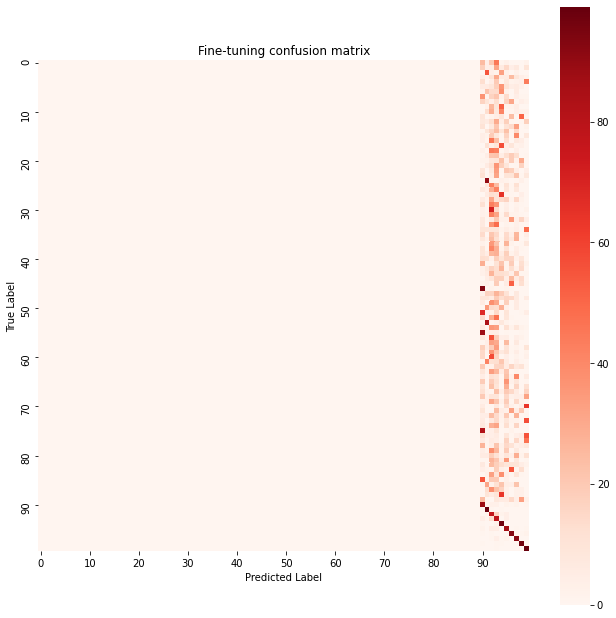

In [ ]:
#COMPUTE CONFUSION MATRIX
#Mapping y_true e y_pred 
diz=test_ds.dict_class_label 
y_t=[]
y_p=[]
for el1,el2 in zip(y_true,y_pred):
  y_t.append(diz[el1]) 
  y_p.append(diz[el2]) 

acc_matrix = confusion_matrix(y_t, y_p)
plt.figure(figsize=(11,11))
df_cm = pd.DataFrame(acc_matrix)
sn.heatmap(df_cm, square=True, xticklabels=10, yticklabels=10, cmap='Reds')
plt.title("Fine-tuning confusion matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
